# Total mass and total radio of models with polytropic master EoS

This code computes the total mass ($M$), the total radius ($r_b$) and the compactness ($\mu_b$) of relativistic anisotropic spheres with master polytropic equation of state
\begin{equation}
    P = \kappa \rho^{1+\frac{1}{n}} + \alpha \rho - \beta \,.
\end{equation}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import integrate
from scipy.integrate import solve_ivp

In [2]:
plt.rc('text', usetex = True)
plt.rc('font', **{'family' : "sans-serif"})
params = {'text.latex.preamble' : [r'\usepackage{amsmath}']}
plt.rcParams.update(params)
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

# Compact object modeling

## Structure equations

The structure equations are the result of manipulating the Einstein field equations for a given metric and energy tensor. They are the equations to be solved to model compact objects. In the case of static conigurations, with spherical symmetry and anisotropic pressure, the structure equations consist of
\begin{eqnarray}
P^{\prime} &=& - \left(\rho + P \right) \frac{m + 4 \pi r^{3} P}{r(r - 2m)} + \frac{2}{r} \left(P_{\perp} - P \right)  \label{EqHid} \tag{1} \\
m^{\prime} &=& 4 \pi r^{2} \rho \label{MasDif} \tag{2}
\end{eqnarray}
where $\rho$ is energy density, $m$ is mass, $P$ is radial pressure and $P_{\perp}$ is tangential pressure. The prime denotes derivative with respect to $r$.

## Equation of State

An equation of state (EoS) is a mathematical model between state variables that describes the most important physical processes that occur in a thermodynamic system. The master polytropic EoS consists of a relationship such that
\begin{equation}
P = \kappa \rho^{1+\frac{1}{n}} + \alpha \rho - \beta \,. \label{PoliMaestra} \tag{3}
\end{equation}

On the other hand, the anisotropic pressure is supposed to be of the form
\begin{equation}
\Delta\equiv P_{\perp} - P = C r (\rho + P) \frac{m + 4 \pi r^3 P}{r(r-2m)} \,, \label{Anisotropia} \tag{4}
\end{equation}
such that equation $\eqref{EqHid}$ is as
\begin{equation}
\frac{\mathrm{d}P}{\mathrm{d}r} = - h \frac{(\rho + P)(m + 4 \pi  r^3 P)}{r(r-2m)} \,, \label{EqHidCos} \tag{5}
\end{equation}
where $h = 1 - 2C$, and $C$ quantifies the anisotropy in the model.

## Lane-Emden equation

The structure equations can be written dimensionless when they are endowed with polytropic EoS. The result is known as the Lane-Emden equation, given by the change of variables
\begin{equation}
\Psi^{n}(\xi) = \frac{\rho}{\rho_{c}} \ , \ \ \eta \left(\xi \right) = \frac{m}{4 \pi \rho_c a^{3}} \quad \textrm{and} \quad r = a\xi \,,
\end{equation}
where
\begin{equation}
a^{2} = \frac{\Upsilon \left(n + 1 \right)}{4 \pi \rho_c} \ , \ \ \Upsilon = \kappa \rho_{c}^{1/n} = \frac{\sigma - \alpha \left(1 - \varkappa \right)}{1 - \varkappa^{1 + \frac{1}{n}}} \ , \ \ \sigma = \frac{P_{c}}{\rho_{c}} \quad \textrm{and} \quad \varkappa = \frac{\rho_{b}}{\rho_{c}} \,.
\end{equation}
The subscripts $c$ and $b$ indicate that the variable is evaluated at the center and surface of the configuration, respectively.

In this way, the dimensionless EoS $\eqref{PoliMaestra}$ and $\eqref{Anisotropia}$ are
\begin{eqnarray}
P &=& \rho_c \left\{\Upsilon \left( \Psi^{n+1} - \varkappa^{1 + \frac{1}{n}} \right) + \alpha \left(\Psi^{n} - \varkappa \right)\right\}  = \rho_c \mathcal{P} \quad \textrm{and} \label{PAdi} \tag{6} \\
\Delta &=& \frac{C \Upsilon (n+1) \left(\eta + \xi^{3} \mathcal{P} \right) \left(\Psi^{n} + \mathcal{P} \right) \rho_{c}}{\xi - 2  \Upsilon \left( n+1 \right) \eta} \,, \label{AniAdi} \tag{7}
\end{eqnarray}
respectively.

Finally, equations $\eqref{EqHidCos}$ and $\eqref{MasDif}$, written in dimensionless form, are
\begin{eqnarray}
\dot{\Psi} &=& - \frac{h \left(\eta + \xi^{3} \mathcal{P}\right) \left(1 + \frac{\mathcal{P}}{\Psi^{n}}\right)}{\xi \left\{\xi-2\,\Upsilon\,\left( n+1 \right) \eta\right\} \left\{1 + \frac{\alpha n}{\Upsilon \left(n+1\right) \Psi}\right\}}  \qquad \textrm{and} \label{PsiPunto} \tag{8} \\
\dot{\eta} &=& \xi^{2}\Psi^{n} \,, \label{EtaPunto} \tag{9}
\end{eqnarray}
where dot indicates derivative with respect to $\xi$.

Therefore, the system of equations to integrate numerically is given by $\eqref{PsiPunto}$ and $\eqref{EtaPunto}$, with initial conditions
\begin{equation}
\Psi (\xi = 0) = \Psi_{c} = 1 \,, \quad \eta (\xi = 0) = \eta_{c} = 0  \,,
\end{equation}
and boundary condition
\begin{equation}
\Psi (\xi = \xi_{b}) = 0 \,.
\end{equation}

In [3]:
# Defining system of equations: derivative of Psi and derivative of Eta as a function of xi
def funciones(xi,y, alpha, n, h, Upsilon, varkappa):
    psi_ , eta_ = y
    dydxi = [-h*(eta_ + xi**(3)*(Upsilon*(psi_**(n+1) - varkappa**(1+1/n)) + alpha*(psi_**(n) - varkappa)))*(1 + Upsilon*(psi_ - (varkappa**(1+1/n)/psi_**(n))) + alpha*(1 - (varkappa/psi_**(n))))/xi/(xi - 2*Upsilon*(n+1)*eta_) /(1 + alpha*n/Upsilon/(n+1)/psi_) 
             ,xi**(2)*psi_**(n)] 
    return dydxi

In [4]:
c = 2.997*10**(8)          # Speed of light in S.I.
G = 6.673*10**(-11)        # Universal gravitational constant in S.I.
Msun = 1.989*10**(30)      # Solar mass in S.I.

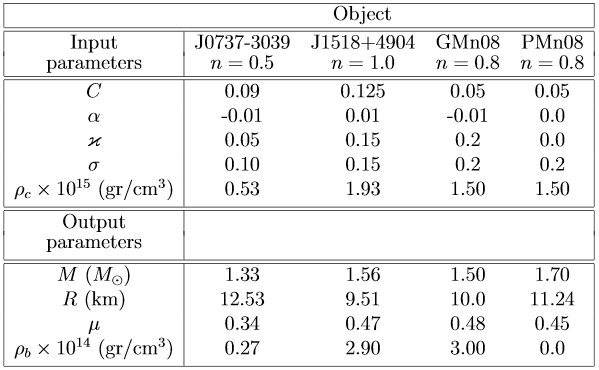

In [5]:
# The input parameters that characterize each model are defined: n, C, alpha, varkappa, sigma and central density

n = 0.8 # Polytropic index

C = 0.05 # Anisotropic factor

h = 1 - 2*C  

alpha = -0.01 # linear term value

varkappa = 0.2 # Ratio between surface density and central density

sigma = 0.2 # Ratio between central pressure and central density

rho_c = 1.5*10**(18) # Central density

# Cálculo de Upsilon
Upsilon = (sigma - alpha*(1 - varkappa))/(1 - varkappa**(1 + 1/n)) 

# Calculation of kappa as a function of Upsilon and central density
K = Upsilon*c**(2)/rho_c**(1/n)      # k**(n) en m**(3)/kg

In [6]:
# Initial conditions
Psi0 = 1.0
Eta0 = 0.0
y0 = [Psi0,Eta0]

# Integration interval
xi0 = 10**(-15) # Start
ximax = 1000    # End, in case the condition to stop integration is not fulfilled
xi_span = (xi0,ximax) # Integration space

# Condition to stop integration (Dimensionless pressure less than 10**(-15))
def stop_condition(xi,y,alpha, n, h, Upsilon, varkappa):
    return (1/sigma)*(Upsilon*(y[0]**(n+1) - varkappa**(1 + 1/n)) + alpha*(y[0]**(n) - varkappa)) - 10**-15
stop_condition.terminal = True

# Solution of the system of equations using the routine "solve_ivp" by means of the RK45 method
# solve_ivp(Equations to integrate, Integration space, Initial conditions, Integration method,
#           Condition to stop integration)
soluciones = solve_ivp(funciones,xi_span,y0,method='RK45',events=stop_condition,
                       args=(alpha, n, h, Upsilon, varkappa))
xi = soluciones.t 
Psi = soluciones.y[0]
Eta = soluciones.y[1]

The total mass (in solar mass unit) and total radius (in kilometers) are given by
\begin{equation}
M = \left\{\frac{c^{2}(n+1)}{(4 \pi)^{\frac{1}{3}} G} \right\}^{\frac{3}{2}} \left(\frac{\kappa}{c^{2}} \right)^{\frac{n}{2}} \Upsilon^{\frac{3-n}{2}} \eta_{b} \,, \quad R = \left\{\frac{c^{2}(n+1)}{4 \pi G} \right\}^{\frac{1}{2}} \left(\frac{\kappa}{c^{2}} \right)^{\frac{n}{2}} \Upsilon^{\frac{1-n}{2}} \xi_{b} \,,
\end{equation}
respectivevly.

In [7]:
# Calculation of the total mass in solar mass unit
M = (c**(2)*(n+1)/(4*np.pi)**(1/3)/G)**(3/2)*(K/c**(2))**(n/2)*sigma**((3-n)/2)*Eta[-1]/Msun  # Masa en unidades de masa solar

# Calculation of the total radius in kilometers
R = (c**(2)*(n+1)/4/np.pi/G)**(1/2)*(K/c**(2))**(n/2)*sigma**((1-n)/2)*xi[-1]/1000

# calculation of the compactness
mr = (2*Upsilon*(n+1)*Eta/xi)[-1]

print(f'Total Mass: {M:.2f} [M\u2609], Total radius: {R:.2f} [km], Compactness(\u03bc): {mr:.2f}')

Total Mass: 1.51 [M☉], Total radius: 9.97 [km], Compactness(μ): 0.48
